## Data Analize

### Import the Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.cluster import KMeans
import os

#### Combine the data files together

In [2]:
data_dir = 'dataset/'
csv_files = [f for f in os.listdir(data_dir) if f.endswith('.csv')]

# Load and combine all data
df_list = [pd.read_csv(os.path.join(data_dir, file)) for file in csv_files]
df_combined = pd.concat(df_list, ignore_index=True)

# Check the combined dataframe
print(df_combined.shape)
print(df_combined.head())

(2830743, 79)
    Destination Port   Flow Duration   Total Fwd Packets  \
0              54865               3                   2   
1              55054             109                   1   
2              55055              52                   1   
3              46236              34                   1   
4              54863               3                   2   

    Total Backward Packets  Total Length of Fwd Packets  \
0                        0                           12   
1                        1                            6   
2                        1                            6   
3                        1                            6   
4                        0                           12   

    Total Length of Bwd Packets   Fwd Packet Length Max  \
0                             0                       6   
1                             6                       6   
2                             6                       6   
3                             6   

### Data Pre Process

In [3]:
# Remove leading/trailing spaces from column names
df_combined.columns = df_combined.columns.str.strip()

In [4]:
# Handle missing values
df_combined = df_combined.dropna()

In [5]:
# Basic statistics
print(df_combined.describe())

       Destination Port  Flow Duration  Total Fwd Packets  \
count      2.829385e+06   2.829385e+06       2.829385e+06   
mean       8.071249e+03   1.479276e+07       9.364763e+00   
std        1.828343e+04   3.366026e+07       7.498527e+02   
min        0.000000e+00  -1.300000e+01       1.000000e+00   
25%        5.300000e+01   1.550000e+02       2.000000e+00   
50%        8.000000e+01   3.132700e+04       2.000000e+00   
75%        4.430000e+02   3.221416e+06       5.000000e+00   
max        6.553500e+04   1.200000e+08       2.197590e+05   

       Total Backward Packets  Total Length of Fwd Packets  \
count            2.829385e+06                 2.829385e+06   
mean             1.039869e+01                 5.495661e+02   
std              9.976276e+02                 9.995980e+03   
min              0.000000e+00                 0.000000e+00   
25%              1.000000e+00                 1.200000e+01   
50%              2.000000e+00                 6.200000e+01   
75%             

In [6]:
# Check label distribution
print(df_combined['Label'].value_counts())

Label
BENIGN                        2272688
DoS Hulk                       230124
PortScan                       158930
DDoS                           128027
DoS GoldenEye                   10293
FTP-Patator                      7938
SSH-Patator                      5897
DoS slowloris                    5796
DoS Slowhttptest                 5499
Bot                              1966
Web Attack � Brute Force         1507
Web Attack � XSS                  652
Infiltration                       36
Web Attack � Sql Injection         21
Heartbleed                         11
Name: count, dtype: int64


##### Handle Infinite Values

In [7]:
import numpy as np
import pandas as pd

# Select only numeric columns
numeric_cols = df_combined.select_dtypes(include=[np.number]).columns

In [8]:
# Find columns with infinite values (numeric only)
inf_cols = df_combined[numeric_cols].columns[np.isinf(df_combined[numeric_cols]).any()]
print("Columns with infinite values:", inf_cols)

Columns with infinite values: Index(['Flow Bytes/s', 'Flow Packets/s'], dtype='object')


In [9]:
# Make a copy to preserve original data
df_clean = df_combined.copy()

# Handle infinite values in numeric columns only
for col in numeric_cols:
    if col in inf_cols:
        # Replace inf with max finite value or NaN
        max_finite = df_clean[col][np.isfinite(df_clean[col])].max()
        df_clean[col] = df_clean[col].replace([np.inf, -np.inf], max_finite)

In [10]:
# Check if any infinite values remain
print("Remaining infinite values:", np.isinf(df_clean[numeric_cols]).any().any())

Remaining infinite values: False


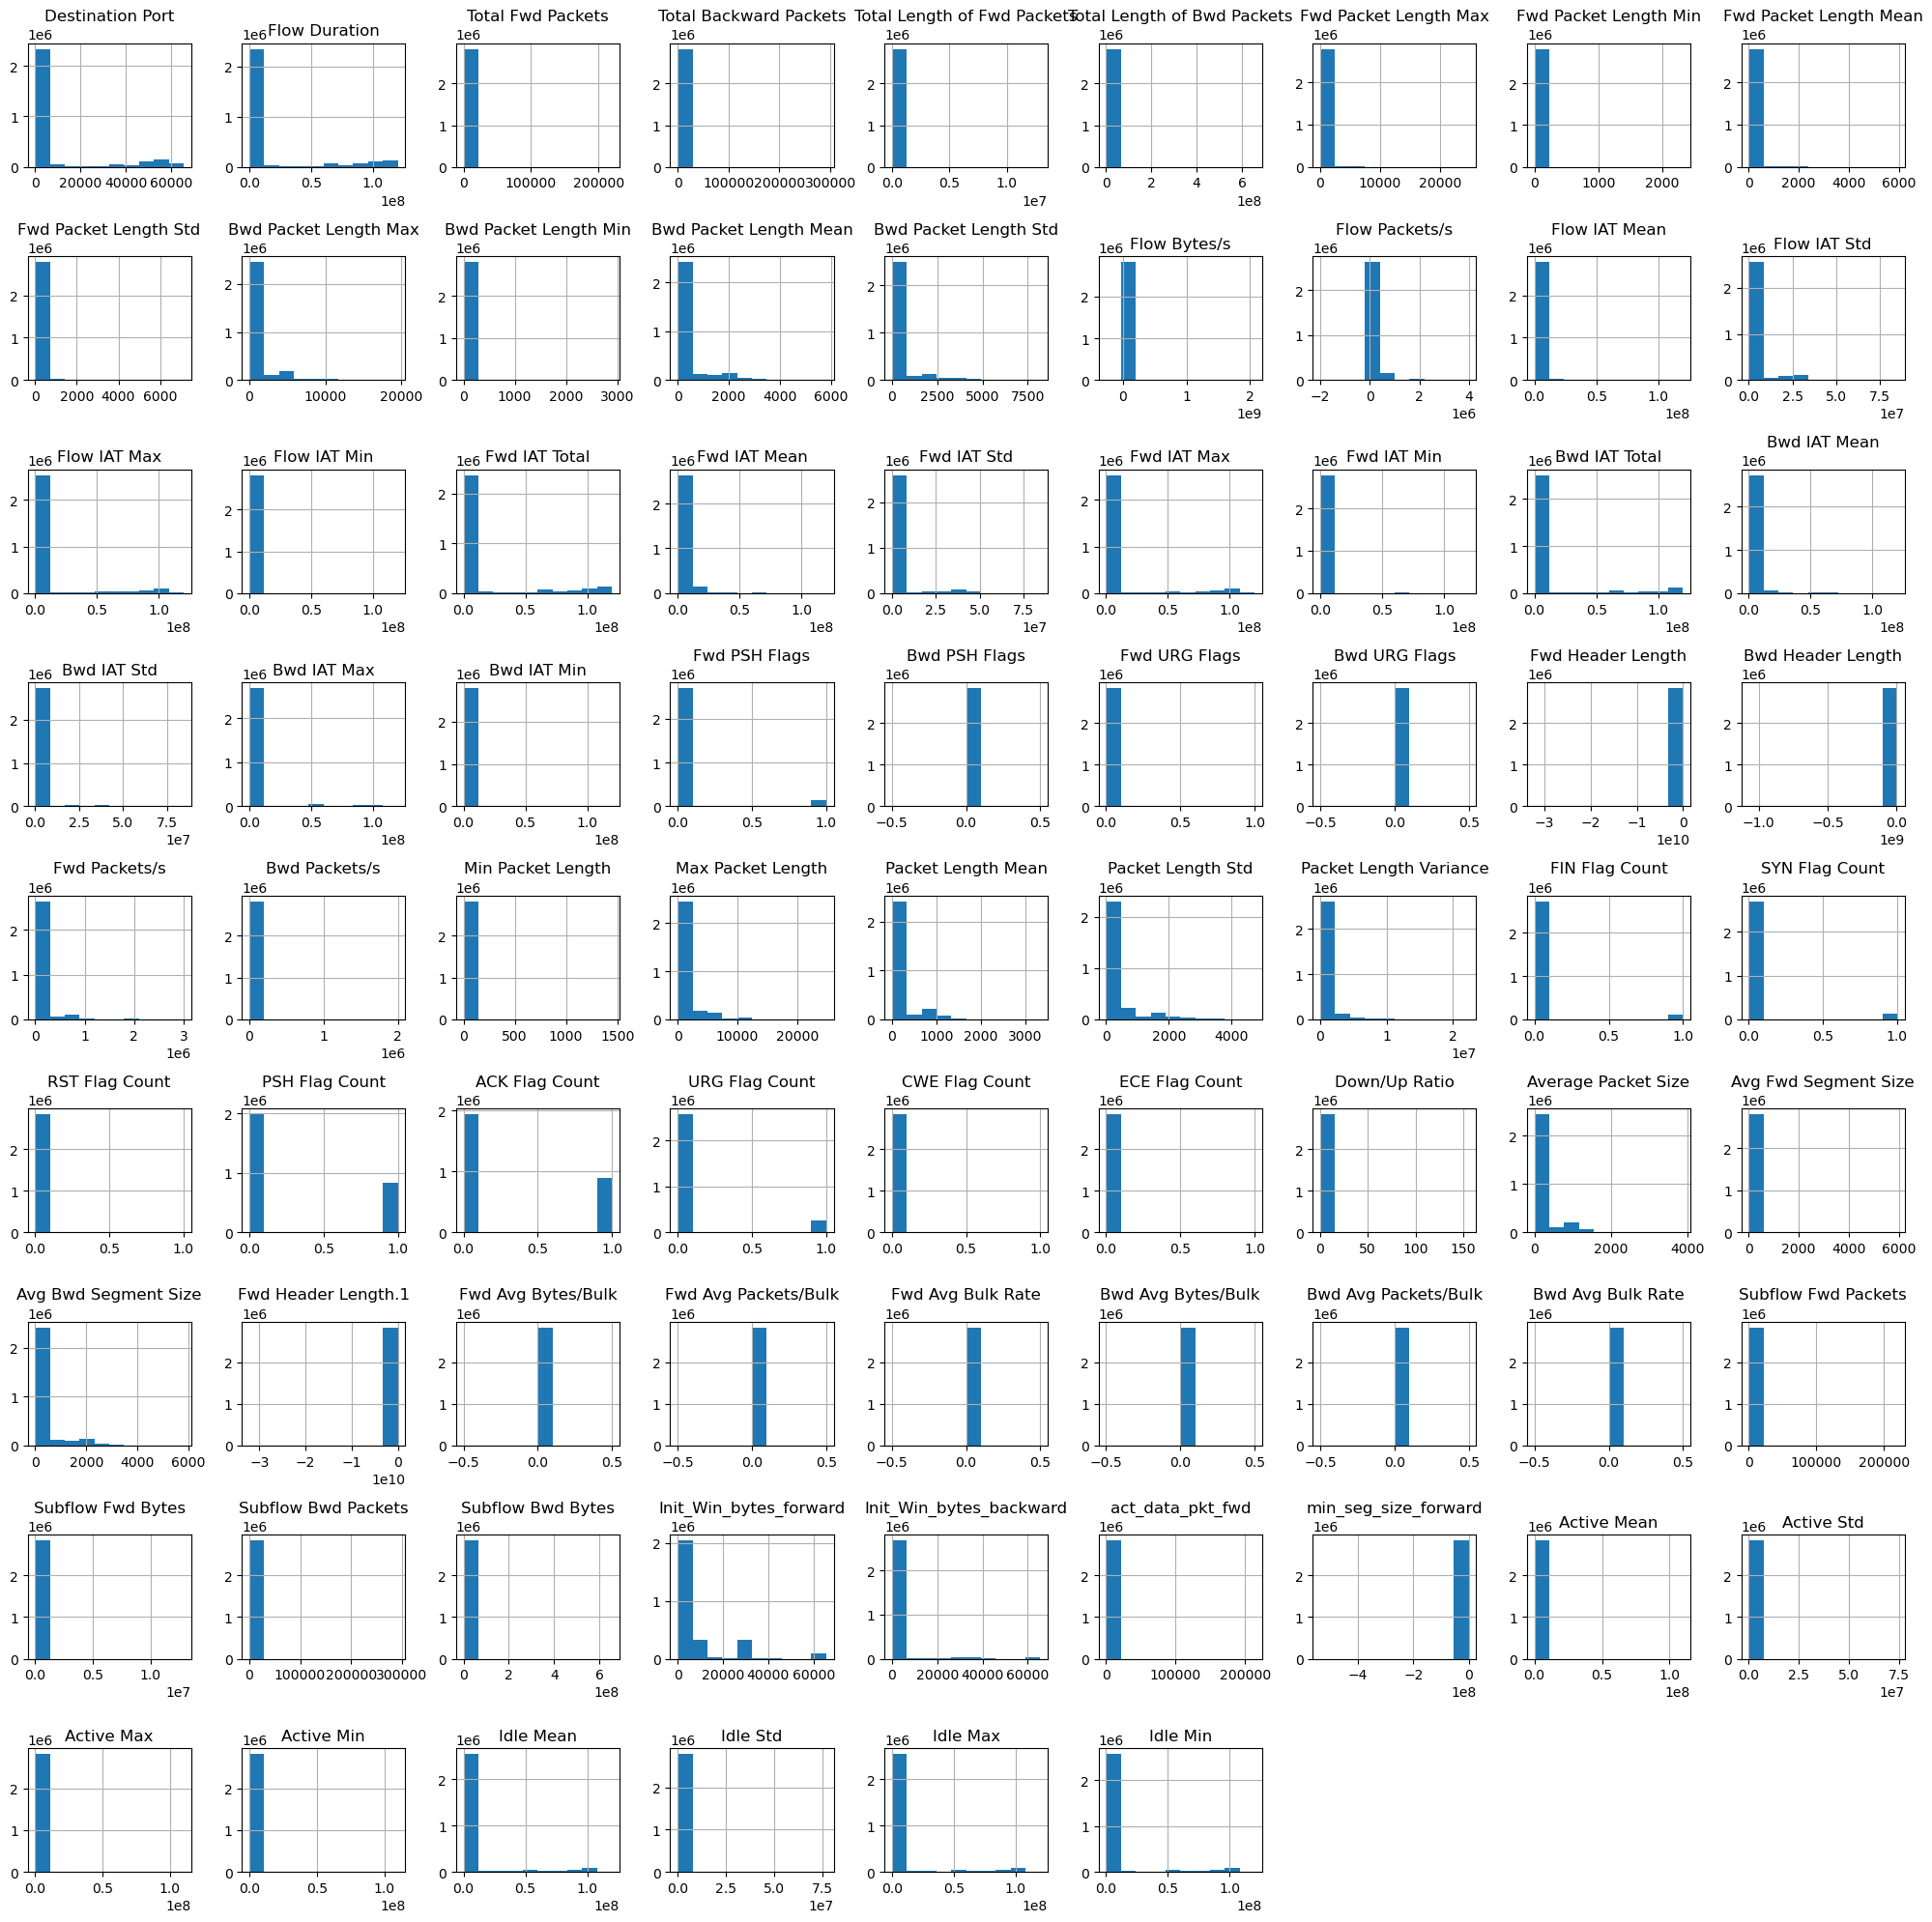

In [11]:
# Visualize feature distributions
import matplotlib.pyplot as plt
df_clean.hist(figsize=(20, 20))
plt.tight_layout()
plt.show()

#### Label Encoding

In [12]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder
encoder = LabelEncoder()

df_clean['Label'] = encoder.fit_transform(df_clean['Label'])

## Feature Engineering

#### Normalize/Scale Features

In [13]:
# Separate features and labels
X = df_clean.drop('Label', axis=1)
y = df_clean['Label']

# Scale numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#### Feature Selection

In [14]:
from sklearn.feature_selection import SelectKBest, f_classif

# Select top 20 features
selector = SelectKBest(score_func=f_classif, k=20)
X_selected = selector.fit_transform(X_scaled, y)

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [31 33 56 57 58 59 60 61] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


### Supervise Learning

##### Random Forrest

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [16]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3)

In [17]:
# Train model
model = RandomForestClassifier(n_estimators=100)
model.fit(X_train, y_train)

RandomForestClassifier()

In [18]:
# Save the model
import joblib

# Save the trained model to a file
joblib.dump(model, 'random_forest_model.pkl')

# To load the model
# model = joblib.load('random_forest_model.pkl')

['random_forest_model.pkl']

### Evaluations

In [19]:
# Generate predictions for y_test
y_pred = model.predict(X_test)

In [20]:
from sklearn.metrics import roc_auc_score

# Get predicted probabilities for each class (not just labels)
y_pred_prob = model.predict_proba(X_test)

# Calculate the ROC AUC score (one-vs-rest approach)
roc_auc = roc_auc_score(y_test, y_pred_prob, average='macro', multi_class='ovr')
print("\nROC AUC Score (macro-average):", roc_auc)


ROC AUC Score (macro-average): 0.9969663521066799


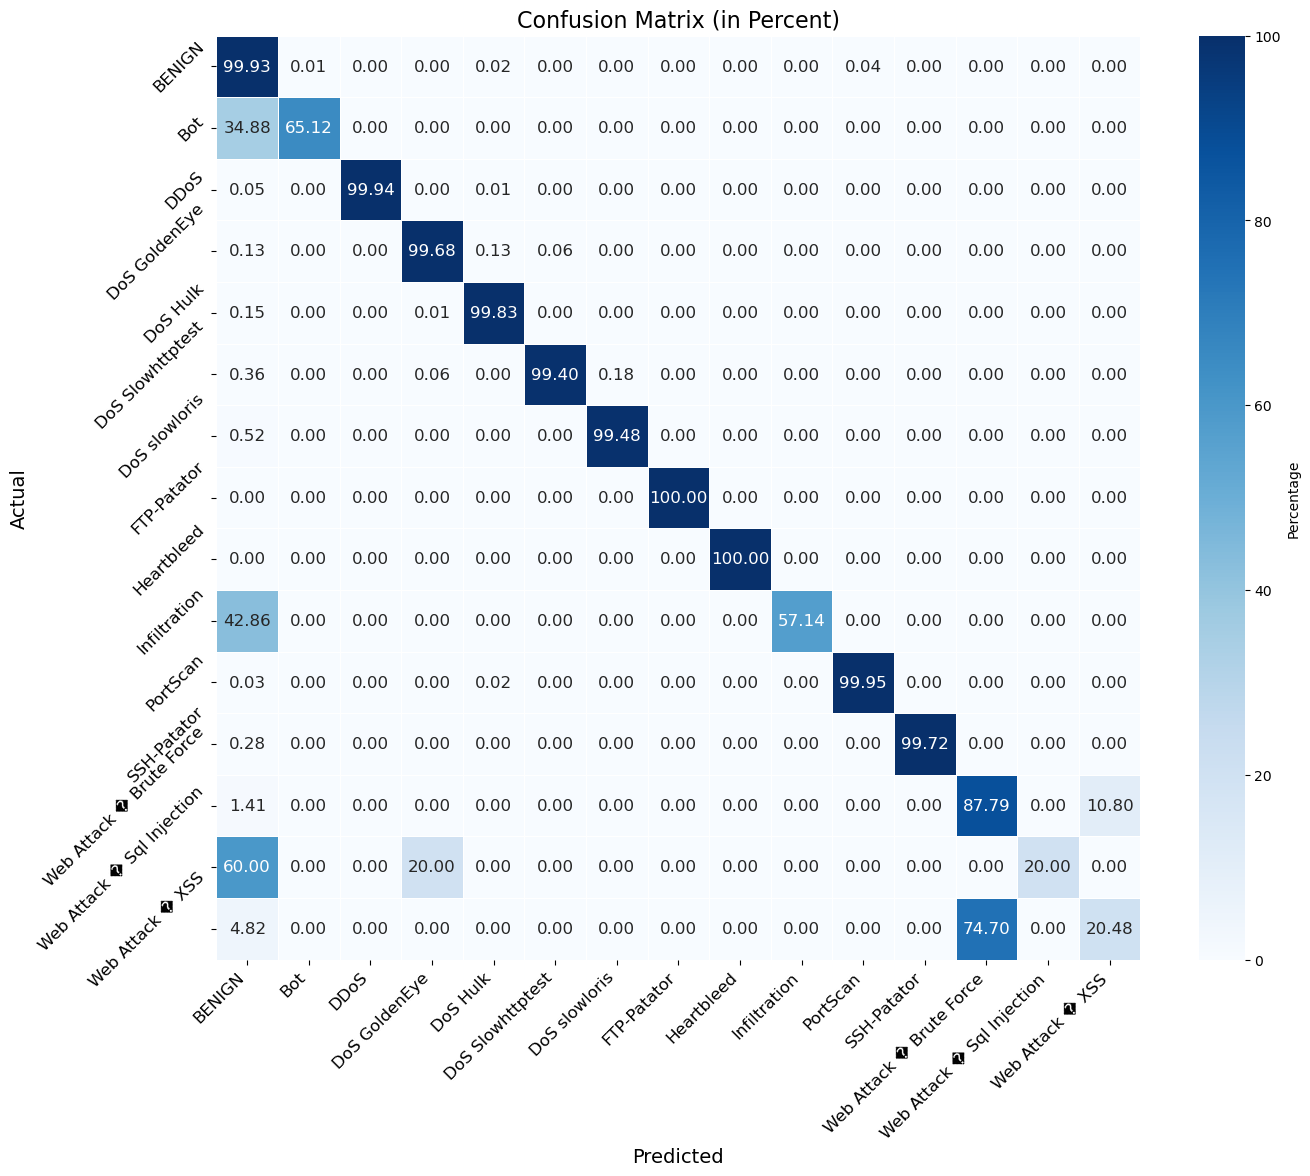

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

# Assuming y_test and y_pred are already defined

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a heatmap
plt.figure(figsize=(15, 12))  

# Annotate with percentages instead of raw numbers for better clarity
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Use the 'encoder' object to get the class labels for xticklabels and yticklabels
sns.heatmap(cm_percentage, annot=True, fmt='.2f', cmap='Blues', 
            xticklabels=encoder.classes_, 
            yticklabels=encoder.classes_,
            cbar_kws={'label': 'Percentage'},  # Color bar label for percentages
            annot_kws={"size": 12},  # Increase annotation font size
            linewidths=0.5,  # Add lines between the cells for separation
            square=True)  # Make the heatmap square for better comparison

# Title and labels
plt.title('Confusion Matrix (in Percent)', fontsize=16)
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('Actual', fontsize=14)

# Rotate the tick labels for better readability
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(rotation=45, ha='right', fontsize=12)

plt.show()

In [22]:
from sklearn.metrics import accuracy_score

# Training Accuracy
train_accuracy = model.score(X_train, y_train)
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")

# Validation Accuracy (Test Accuracy)
val_accuracy = model.score(X_test, y_test)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

Training Accuracy: 99.94%
Validation Accuracy: 99.88%


AUC-ROC score (One-vs-Rest): 0.9969663521066799


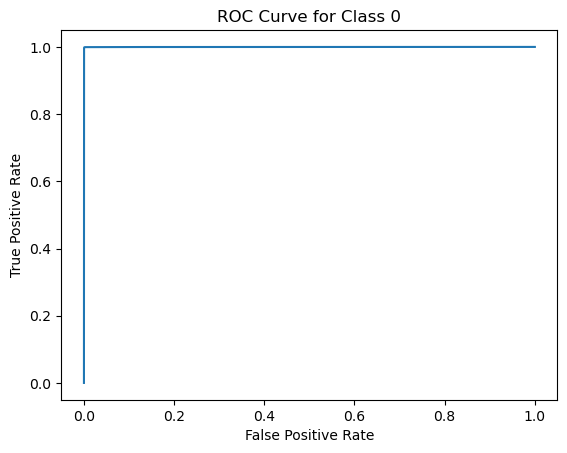

In [23]:
from sklearn.metrics import roc_auc_score, roc_curve

# Get predicted probabilities for each class
y_pred_prob = model.predict_proba(X_test)

# Calculate AUC-ROC score
auc_roc = roc_auc_score(y_test, y_pred_prob, multi_class='ovr')

# Calculate ROC curve for each class (example for class 0)
fpr, tpr, thresholds = roc_curve(y_test == 0, y_pred_prob[:, 0])

print("AUC-ROC score (One-vs-Rest):", auc_roc)

# You can also plot the ROC curve for class 0 as an example
import matplotlib.pyplot as plt
plt.plot(fpr, tpr, label="Class 0")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Class 0')
plt.show()

In [24]:
from sklearn.metrics import classification_report

# Assuming your model is already trained and you have X_test, y_test
y_pred = model.predict(X_test)

# Generate and print the classification report
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    682134
           1       0.89      0.65      0.75       605
           2       1.00      1.00      1.00     38342
           3       1.00      1.00      1.00      3096
           4       1.00      1.00      1.00     69080
           5       0.99      0.99      0.99      1677
           6       1.00      0.99      1.00      1721
           7       1.00      1.00      1.00      2288
           8       1.00      1.00      1.00         2
           9       1.00      0.57      0.73        14
          10       0.99      1.00      1.00     47464
          11       1.00      1.00      1.00      1796
          12       0.75      0.88      0.81       426
          13       1.00      0.20      0.33         5
          14       0.42      0.20      0.28       166

    accuracy                           1.00    848816
   macro avg       0.94      0.83      0.86    848816
weighted avg       1.00   